# Prophet API & Wrapper Functions Tutorial

**Author**: Ibrahim Ahmed Mohammed  
**Course**: DATA610

---



---

## Table of Contents

1. [Setup and Imports](#1-setup-and-imports)
2. [Native Prophet API](#2-native-prophet-api)
3. [ProphetWrapper Class](#3-prophetwrapper-class)
4. [Data Loading Utilities](#4-data-loading-utilities)
5. [Intervention/Holiday Functions](#5-interventionholiday-functions)
6. [ARIMA/SARIMA Functions](#6-arimasarima-functions)
7. [LSTMForecaster Class](#7-lstmforecaster-class)
8. [Evaluation Metrics](#8-evaluation-metrics)
9. [Visualization Functions](#9-visualization-functions)
10. [Helper Functions](#10-helper-functions)

---

## 1. Setup and Imports

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Native Prophet
from prophet import Prophet

# Our custom utilities
from utils import (
    # ProphetWrapper class
    ProphetWrapper,
    
    # Data loading
    load_jhu_timeseries,
    get_available_countries,
    prepare_prophet_data,
    summarize_data,
    train_test_split_temporal,
    
    # Interventions/Holidays
    create_intervention_dataframe,
    get_us_covid_interventions,
    get_country_interventions,
    
    # Statistical models
    fit_arima,
    fit_sarima,
    forecast_arima,
    forecast_sarima,
    
    # Deep learning
    LSTMForecaster,
    
    # Metrics
    calculate_rmse,
    calculate_mae,
    calculate_smape,
    evaluate_forecast,
    compare_models,
    
    # Visualization
    plot_forecast,
    plot_components,
    plot_intervention_effects,
    plot_model_comparison,
    plot_training_history,
    plot_forecast_comparison
)

print("All imports successful!")

All imports successful!


### Create Sample Data for Demonstrations

We'll create synthetic time series data to demonstrate the API without tying it to any specific project.

In [36]:
# Create synthetic time series data with trend, seasonality, and noise
np.random.seed(42)

# Generate 2 years of daily data
dates = pd.date_range(start='2022-01-01', periods=730, freq='D')

# Components
trend = np.linspace(100, 200, 730)  # Upward trend
weekly_seasonality = 20 * np.sin(2 * np.pi * np.arange(730) / 7)  # Weekly pattern
yearly_seasonality = 30 * np.sin(2 * np.pi * np.arange(730) / 365)  # Yearly pattern
noise = np.random.normal(0, 10, 730)  # Random noise

# Combine
values = trend + weekly_seasonality + yearly_seasonality + noise
values = np.clip(values, 0, None)  # Ensure non-negative

# Create Prophet-format dataframe
sample_df = pd.DataFrame({
    'ds': dates,
    'y': values
})

print(f"Sample data shape: {sample_df.shape}")
print(f"Date range: {sample_df['ds'].min().date()} to {sample_df['ds'].max().date()}")
sample_df.head()

Sample data shape: (730, 2)
Date range: 2022-01-01 to 2023-12-31


,ds,y
0,2022-01-01,104.967142
1,2022-01-02,114.907562
2,2022-01-03,127.282440
3,2022-01-04,125.868086
4,2022-01-05,91.593561


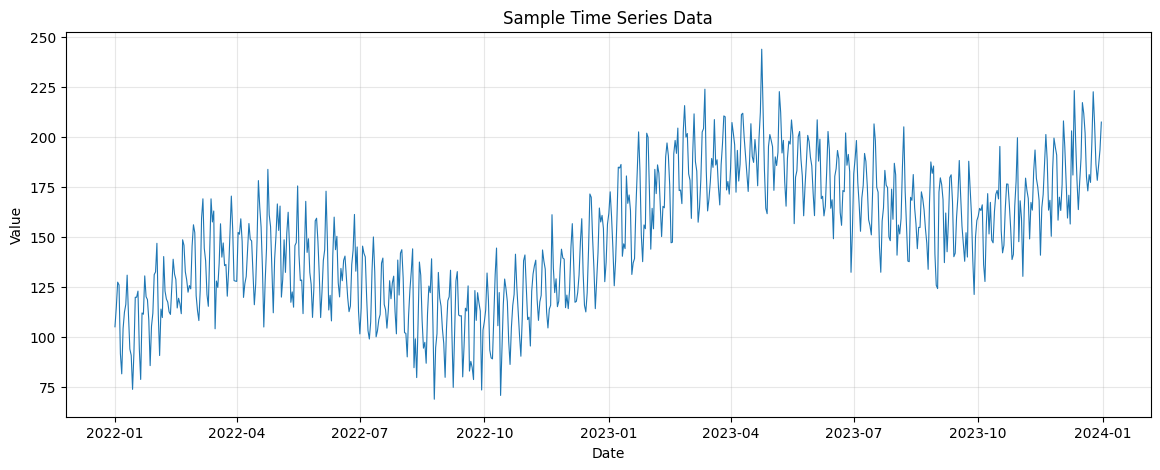

In [37]:
# Visualize the sample data
plt.figure(figsize=(14, 5))
plt.plot(sample_df['ds'], sample_df['y'], linewidth=0.8)
plt.title('Sample Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

---

## 2. Native Prophet API

First, let's see how Prophet works natively (without our wrapper).

### 2.1 Basic Prophet Model

In [38]:
# Initialize Prophet with basic settings
model = Prophet(
    yearly_seasonality=True,   # Capture yearly patterns
    weekly_seasonality=True,   # Capture weekly patterns
    daily_seasonality=False,   # Not needed for daily data
    interval_width=0.95        # 95% confidence intervals
)

# Fit the model
model.fit(sample_df)
print("Model fitted successfully!")

2025-12-16 02:01:19 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:19 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully!


### 2.2 Generate Forecast

In [39]:
# Create future dataframe for 30 days ahead
future = model.make_future_dataframe(periods=30)
print(f"Future dataframe shape: {future.shape}")

# Generate predictions
forecast = model.predict(future)

# Key columns in forecast
print("\nForecast columns:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Future dataframe shape: (760, 1)

Forecast columns:
            ds        yhat  yhat_lower  yhat_upper
755 2024-01-26  196.338962  179.182352  215.103139
756 2024-01-27  213.225866  195.548380  231.723622
757 2024-01-28  229.807872  210.850403  247.539519
758 2024-01-29  232.122311  213.772701  251.001218
759 2024-01-30  223.617377  204.026561  242.166548


### 2.3 Prophet Built-in Plotting

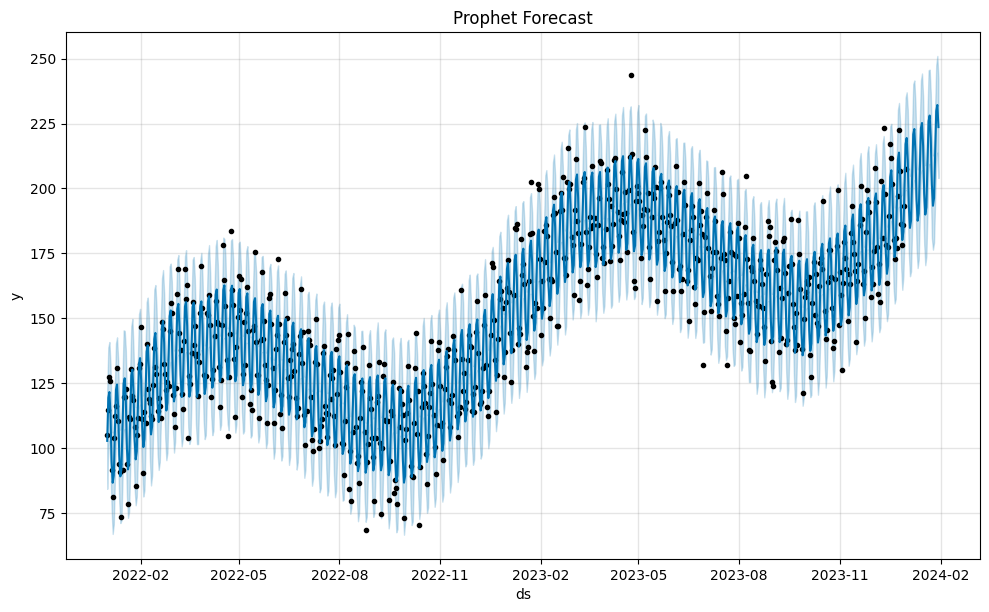

In [40]:
# Prophet's built-in forecast plot
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

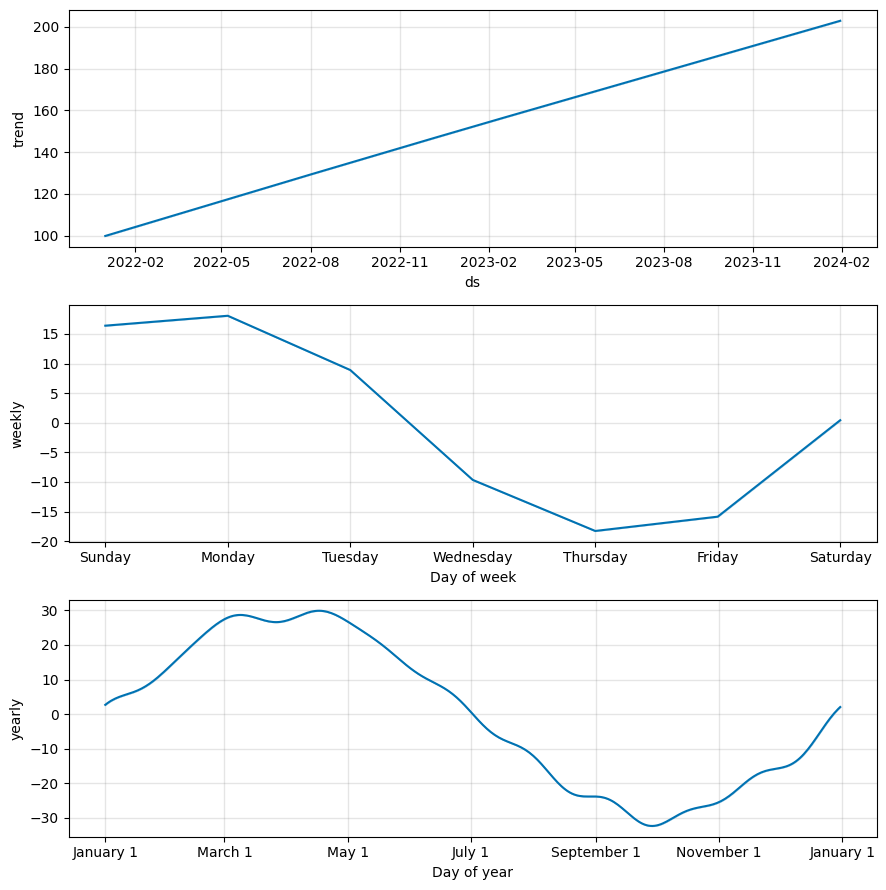

In [41]:
# Prophet's built-in component plot
fig2 = model.plot_components(forecast)
plt.show()

---

## 3. ProphetWrapper Class

Our `ProphetWrapper` class provides a simplified interface with:
- **Method chaining** for cleaner code
- **Automatic non-negative predictions** (essential for count data)
- **Built-in configuration management**

### 3.1 Basic Usage

In [42]:
# Initialize ProphetWrapper
wrapper = ProphetWrapper(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,  # Trend flexibility
    interval_width=0.95            # Confidence interval width
)

# View configuration
print("Wrapper configuration:")
print(wrapper.config)

2025-12-16 02:01:20 - utils - INFO - ProphetWrapper initialized with config: {'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}
2025-12-16 02:01:20 - utils - INFO - Floor constraint: 0.0 (predictions will be non-negative)


Wrapper configuration:
{'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}


### 3.2 Method Chaining

In [43]:
# Method chaining: initialize, fit, and predict in one flow
wrapper = (
    ProphetWrapper(weekly_seasonality=True, yearly_seasonality=True)
    .fit(sample_df)
)

# Generate forecast
wrapper_forecast = wrapper.predict(periods=30)
print(f"Forecast shape: {wrapper_forecast.shape}")
print(wrapper_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

2025-12-16 02:01:20 - utils - INFO - ProphetWrapper initialized with config: {'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}
2025-12-16 02:01:20 - utils - INFO - Floor constraint: 0.0 (predictions will be non-negative)
2025-12-16 02:01:20 - utils - INFO - Fitting Prophet model on 730 observations
2025-12-16 02:01:20 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:20 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:20 - utils - INFO - Prophet model fitted successfully
2025-12-16 02:01:20 - utils - INFO - Generating 30-period forecast
2025-12-16 02:01:20 - utils - INFO - Forecast generated: 760 rows (min yhat: 86.74, max yhat: 232.12)


Forecast shape: (760, 19)
            ds        yhat  yhat_lower  yhat_upper
755 2024-01-26  196.338962  177.428444  217.198144
756 2024-01-27  213.225866  193.596964  232.472602
757 2024-01-28  229.807872  211.270178  247.947351
758 2024-01-29  232.122311  213.158729  250.393807
759 2024-01-30  223.617377  205.199619  243.232713


### 3.3 Adding Holidays/Interventions

In [44]:
# Create custom holidays
custom_holidays = pd.DataFrame({
    'holiday': ['event_1', 'event_2', 'event_3'],
    'ds': pd.to_datetime(['2022-03-15', '2022-07-04', '2022-12-25']),
    'lower_window': 0,
    'upper_window': 7  # Effect lasts 7 days after event
})

print("Custom holidays:")
print(custom_holidays)

Custom holidays:
   holiday         ds  lower_window  upper_window
0  event_1 2022-03-15             0             7
1  event_2 2022-07-04             0             7
2  event_3 2022-12-25             0             7


In [45]:
# Use set_holidays() with method chaining
wrapper_with_holidays = (
    ProphetWrapper(weekly_seasonality=True, yearly_seasonality=True)
    .set_holidays(custom_holidays)
    .fit(sample_df)
)

forecast_with_holidays = wrapper_with_holidays.predict(periods=30)
print("Forecast with holidays generated!")

2025-12-16 02:01:21 - utils - INFO - ProphetWrapper initialized with config: {'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}
2025-12-16 02:01:21 - utils - INFO - Floor constraint: 0.0 (predictions will be non-negative)
2025-12-16 02:01:21 - utils - INFO - Set 3 holidays/interventions
2025-12-16 02:01:21 - utils - INFO - Fitting Prophet model on 730 observations
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - utils - INFO - Prophet model fitted successfully
2025-12-16 02:01:21 - utils - INFO - Generating 30-period forecast
2025-12-16 02:01:21 - utils - INFO - Forecast generated: 760 rows (min yhat: 86.48, max yhat: 232.48)


Forecast with holidays generated!


### 3.4 Adding External Regressors

In [46]:
# Add a regressor column to our data
sample_df_with_regressor = sample_df.copy()
sample_df_with_regressor['temperature'] = 20 + 10 * np.sin(2 * np.pi * np.arange(730) / 365)

# Use add_regressor() with method chaining
wrapper_with_regressor = (
    ProphetWrapper(weekly_seasonality=True, yearly_seasonality=True)
    .add_regressor('temperature', prior_scale=10.0, mode='additive')
    .fit(sample_df_with_regressor)
)

print("Model with external regressor fitted!")

2025-12-16 02:01:21 - utils - INFO - ProphetWrapper initialized with config: {'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}
2025-12-16 02:01:21 - utils - INFO - Floor constraint: 0.0 (predictions will be non-negative)
2025-12-16 02:01:21 - utils - INFO - Added regressor: temperature (prior_scale=10.0, mode=additive)
2025-12-16 02:01:21 - utils - INFO - Fitting Prophet model on 730 observations
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - utils - INFO - Prophet model fitted successfully


Model with external regressor fitted!


### 3.5 Cross-Validation

In [47]:
# Perform cross-validation
wrapper = ProphetWrapper(weekly_seasonality=True, yearly_seasonality=True).fit(sample_df)

cv_results = wrapper.cross_validate(
    initial='365 days',  # Initial training period
    period='30 days',    # Spacing between cutoffs
    horizon='28 days'    # Forecast horizon
)

print(f"Cross-validation results shape: {cv_results.shape}")
cv_results.head()

2025-12-16 02:01:21 - utils - INFO - ProphetWrapper initialized with config: {'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}
2025-12-16 02:01:21 - utils - INFO - Floor constraint: 0.0 (predictions will be non-negative)
2025-12-16 02:01:21 - utils - INFO - Fitting Prophet model on 730 observations
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - utils - INFO - Prophet model fitted successfully
2025-12-16 02:01:21 - utils - INFO - Running cross-validation: initial=365 days, period=30 days, horizon=28 days
2025-12-16 02:01:21 - prophet - INFO - Making 12 forecasts with cutoffs between 2023-01-07 00:00:00 and 2023-12-03 00:00:00
2025-12-16 02:01:21 - prophet - WARNING - Seasonality has period of 365.25 days wh

  0%|          | 0/12 [00:00<?, ?it/s]

2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:21 - cmdstanpy - INFO - Chain [1] star

Cross-validation results shape: (336, 6)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-08,168.710660,151.306047,187.979339,184.783114,2023-01-07
1,2023-01-09,169.671599,152.062009,186.910424,184.375610,2023-01-07
2,2023-01-10,160.908573,144.509386,178.062348,186.141919,2023-01-07
3,2023-01-11,142.364283,124.683910,159.288568,140.227973,2023-01-07
4,2023-01-12,132.365592,114.307963,150.384726,146.448953,2023-01-07


In [48]:
# Get performance metrics from CV
cv_metrics = wrapper.get_performance_metrics(cv_results)
print("Cross-validation metrics:")
cv_metrics[['horizon', 'rmse', 'mae', 'smape']].head(10)

2025-12-16 02:01:22 - utils - INFO - Calculating performance metrics from cross-validation
2025-12-16 02:01:22 - utils - INFO - Metrics calculated for 26 horizons


Cross-validation metrics:


,horizon,rmse,mae,smape
0,3 days,11.149960,8.697143,0.050745
1,4 days,10.860972,8.345171,0.048782
2,5 days,11.303373,8.877694,0.052052
3,6 days,10.490447,8.056047,0.046968
4,7 days,11.737744,9.162751,0.053161
5,8 days,10.888071,8.347044,0.047195
6,9 days,9.926200,7.707270,0.043592
7,10 days,10.892912,8.429353,0.047394
8,11 days,12.654657,10.336632,0.059882
9,12 days,12.721809,10.629933,0.061590


### 3.6 Logistic Growth (Bounded Forecasts)

In [49]:
# Logistic growth with floor and cap
wrapper_logistic = ProphetWrapper(
    growth='logistic',      # Use logistic growth
    floor=0,                # Minimum value
    cap=300,                # Maximum value (auto-calculated if None)
    weekly_seasonality=True,
    yearly_seasonality=True
).fit(sample_df)

logistic_forecast = wrapper_logistic.predict(periods=30)
print(f"Logistic forecast range: {logistic_forecast['yhat'].min():.1f} to {logistic_forecast['yhat'].max():.1f}")

2025-12-16 02:01:22 - utils - INFO - ProphetWrapper initialized with config: {'growth': 'logistic', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}
2025-12-16 02:01:22 - utils - INFO - Floor constraint: 0 (predictions will be non-negative)
2025-12-16 02:01:22 - utils - INFO - Fitting Prophet model on 730 observations
2025-12-16 02:01:22 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:22 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:22 - utils - INFO - Prophet model fitted successfully
2025-12-16 02:01:22 - utils - INFO - Generating 30-period forecast
2025-12-16 02:01:22 - utils - INFO - Forecast generated: 760 rows (min yhat: 86.53, max yhat: 231.12)


Logistic forecast range: 86.5 to 231.1


---

## 4. Data Loading Utilities

Functions for loading and preparing time series data.

### 4.1 load_jhu_timeseries()

Load Johns Hopkins COVID-19 time series data (or similar wide-format data).

In [50]:
# Function signature and docstring
help(load_jhu_timeseries)

Help on function load_jhu_timeseries in module utils:

load_jhu_timeseries(filepath: str, country: str = 'US') -> pandas.core.frame.DataFrame
    Load and transform Johns Hopkins COVID-19 time series data.
    
    JHU format has rows as countries/provinces and columns as dates.
    Data available from Jan 2020 to March 2023.
    
    Parameters
    ----------
    filepath : str
        Path to JHU time series CSV file
    country : str
        Country name to filter (default 'US')
        
    Returns
    -------
    pd.DataFrame
        Prophet-formatted dataframe with 'ds' and 'y' columns (daily new cases)



In [51]:
# Example usage (requires JHU data file)
# df = load_jhu_timeseries('jhu_confirmed_global.csv', country='US')
# df.head()

### 4.2 get_available_countries()

List all countries available in the dataset.

In [52]:
# Function signature
help(get_available_countries)

Help on function get_available_countries in module utils:

get_available_countries(filepath: str) -> List[str]
    Get list of available countries in JHU dataset.
    
    Parameters
    ----------
    filepath : str
        Path to JHU time series CSV file
        
    Returns
    -------
    list
        List of country names



### 4.3 summarize_data()

Generate summary statistics for time series data.

In [53]:
# Summarize our sample data
summary = summarize_data(sample_df)
print("Data Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

2025-12-16 02:01:22 - utils - INFO - Generating data summary statistics
2025-12-16 02:01:22 - utils - INFO - Data summary: 730 observations from 2022-01-01 to 2023-12-31


Data Summary:
  start_date: 2022-01-01 00:00:00
  end_date: 2023-12-31 00:00:00
  n_observations: 730
  mean: 149.88108145308016
  std: 32.74122517274388
  min: 68.73764383090437
  max: 243.77835723600893
  missing_values: 0


### 4.4 train_test_split_temporal()

Split time series data chronologically (no data leakage).

In [54]:
# Split data: last 28 days for test
train_df, test_df = train_test_split_temporal(sample_df, test_size=28)

print(f"Training set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")
print(f"\nTrain dates: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}")
print(f"Test dates: {test_df['ds'].min().date()} to {test_df['ds'].max().date()}")

2025-12-16 02:01:22 - utils - INFO - Splitting data: 702 train, 28 test


Training set: 702 rows
Test set: 28 rows

Train dates: 2022-01-01 to 2023-12-03
Test dates: 2023-12-04 to 2023-12-31


---

## 5. Intervention/Holiday Functions

Functions for creating and managing intervention/holiday effects.

### 5.1 create_intervention_dataframe()

Convert a dictionary of events to Prophet's holiday format.

In [55]:
# Define interventions as a dictionary
my_interventions = {
    'product_launch': '2022-04-01',
    'marketing_campaign': '2022-06-15',
    'price_change': '2022-09-01',
    'holiday_season': '2022-12-01'
}

# Convert to Prophet format
holidays_df = create_intervention_dataframe(my_interventions)
print("Intervention DataFrame:")
holidays_df

2025-12-16 02:01:22 - utils - INFO - Creating intervention dataframe with 4 events


Intervention DataFrame:


,holiday,ds,lower_window,upper_window
0,product_launch,2022-04-01,0,14
1,marketing_campaign,2022-06-15,0,14
2,price_change,2022-09-01,0,14
3,holiday_season,2022-12-01,0,14


### 5.2 get_us_covid_interventions()

Get pre-defined US COVID-19 intervention dates.

In [56]:
# Get US interventions
us_interventions = get_us_covid_interventions()
print("US COVID-19 Interventions:")
for name, date in us_interventions.items():
    print(f"  {name}: {date}")

US COVID-19 Interventions:
  national_emergency: 2020-03-13
  lockdowns_begin: 2020-03-19
  reopening_phase1: 2020-05-01
  summer_surge: 2020-07-01
  fall_surge: 2020-10-15
  vaccine_auth: 2020-12-11
  vaccine_rollout: 2021-01-15
  delta_surge: 2021-07-01
  omicron_surge: 2021-12-15


### 5.3 get_country_interventions()

Get intervention dates for specific countries.

In [57]:
# Get interventions for different countries
for country in ['US', 'Germany', 'Brazil', 'India']:
    interventions = get_country_interventions(country)
    print(f"\n{country} interventions: {len(interventions)} events")
    for name, date in list(interventions.items())[:3]:  # Show first 3
        print(f"  - {name}: {date}")


US interventions: 9 events
  - national_emergency: 2020-03-13
  - lockdowns_begin: 2020-03-19
  - reopening_phase1: 2020-05-01

Germany interventions: 5 events
  - first_lockdown: 2020-03-22
  - reopening: 2020-05-06
  - second_lockdown: 2020-11-02

Brazil interventions: 5 events
  - first_case: 2020-02-26
  - state_lockdowns: 2020-03-24
  - peak_first_wave: 2020-07-29

India interventions: 5 events
  - lockdown_start: 2020-03-25
  - unlock_1: 2020-06-01
  - second_wave: 2021-03-01


---

## 6. ARIMA/SARIMA Functions

Statistical baseline models for comparison with Prophet.

### 6.1 fit_arima()

Fit an ARIMA model.

In [58]:
# Fit ARIMA model
# Order (p, d, q): p=AR terms, d=differencing, q=MA terms
arima_model, arima_fitted = fit_arima(
    train_df, 
    order=(5, 1, 0)  # AR(5) with first differencing
)

print(f"ARIMA model fitted")
print(f"AIC: {arima_model.aic:.2f}")
print(f"BIC: {arima_model.bic:.2f}")

2025-12-16 02:01:22 - utils - INFO - Fitting ARIMA(5, 1, 0) model
2025-12-16 02:01:22 - utils - INFO - ARIMA model fitted. AIC: 5552.65, BIC: 5579.96


ARIMA model fitted
AIC: 5552.65
BIC: 5579.96


### 6.2 forecast_arima()

Generate forecasts from fitted ARIMA model.

In [59]:
# Generate ARIMA forecast
arima_predictions = forecast_arima(arima_model, periods=28)

print(f"ARIMA predictions: {len(arima_predictions)} values")
print(f"Range: {arima_predictions.min():.1f} to {arima_predictions.max():.1f}")

2025-12-16 02:01:22 - utils - INFO - Generating 28-period ARIMA forecast
2025-12-16 02:01:22 - utils - INFO - ARIMA forecast generated: 28 values


ARIMA predictions: 28 values
Range: 161.2 to 197.0


### 6.3 fit_sarima()

Fit a Seasonal ARIMA model.

In [60]:
# Fit SARIMA with weekly seasonality (s=7)
sarima_model, sarima_fitted = fit_sarima(
    train_df,
    order=(1, 1, 1),           # Non-seasonal order
    seasonal_order=(1, 1, 1, 7) # Seasonal order with s=7 (weekly)
)

print(f"SARIMA model fitted")
print(f"AIC: {sarima_model.aic:.2f}")

2025-12-16 02:01:23 - utils - INFO - Fitting SARIMA(1, 1, 1)x(1, 1, 1, 7) model
2025-12-16 02:01:23 - utils - INFO - SARIMA model fitted. AIC: 5280.31, BIC: 5303.02


SARIMA model fitted
AIC: 5280.31


### 6.4 forecast_sarima()

Generate forecasts from fitted SARIMA model.

In [61]:
# Generate SARIMA forecast
sarima_predictions = forecast_sarima(sarima_model, periods=28)

print(f"SARIMA predictions: {len(sarima_predictions)} values")
print(f"Range: {sarima_predictions.min():.1f} to {sarima_predictions.max():.1f}")

2025-12-16 02:01:23 - utils - INFO - Generating 28-period SARIMA forecast
2025-12-16 02:01:23 - utils - INFO - SARIMA forecast generated: 28 values


SARIMA predictions: 28 values
Range: 162.6 to 200.5


---

## 7. LSTMForecaster Class

Deep learning model for complex time series patterns.

### 7.1 Initialize LSTMForecaster

In [62]:
# Initialize LSTM
lstm = LSTMForecaster(
    sequence_length=14,    # Look back 14 time steps
    lstm_units=[64, 32],   # Two LSTM layers with 64 and 32 units
    dropout_rate=0.2,      # 20% dropout for regularization
    learning_rate=0.001    # Adam optimizer learning rate
)

print("LSTMForecaster initialized!")

2025-12-16 02:01:23 - utils - INFO - LSTMForecaster initialized: seq_len=14, units=[64, 32]


LSTMForecaster initialized!


### 7.2 Fit LSTM Model

In [63]:
# Fit LSTM on training data
lstm.fit(
    train_df,
    epochs=50,                      # Maximum epochs
    batch_size=32,                  # Batch size
    validation_split=0.1,           # 10% for validation
    early_stopping_patience=10,     # Stop if no improvement for 10 epochs
    verbose=0                       # Silent training
)

print("LSTM model fitted!")

2025-12-16 02:01:24 - utils - INFO - Fitting LSTM model on 702 observations
2025-12-16 02:01:24 - utils - INFO - Created 688 training sequences
2025-12-16 02:01:24 - utils - INFO - LSTM model built: 29345 parameters
2025-12-16 02:01:31 - utils - INFO - LSTM model fitted. Final loss: 0.011792


LSTM model fitted!


### 7.3 Generate LSTM Forecast

In [64]:
# Generate multi-step forecast
lstm_predictions = lstm.forecast(train_df, periods=28)

print(f"LSTM predictions: {len(lstm_predictions)} values")
print(f"Range: {lstm_predictions.min():.1f} to {lstm_predictions.max():.1f}")

2025-12-16 02:01:31 - utils - INFO - Generating 28-period LSTM forecast
2025-12-16 02:01:32 - utils - INFO - LSTM forecast generated: 28 values


LSTM predictions: 28 values
Range: 180.0 to 189.5


### 7.4 Get Training History

In [65]:
# Get training history
history = lstm.get_training_history()
print(f"Training epochs: {len(history['loss'])}")
print(f"Final loss: {history['loss'][-1]:.6f}")

Training epochs: 26
Final loss: 0.011792


---

## 8. Evaluation Metrics

Functions for measuring forecast accuracy.

### 8.1 Individual Metrics

In [66]:
# Get actual values from test set
actual = test_df['y'].values

# Calculate individual metrics
rmse = calculate_rmse(actual, arima_predictions)
mae = calculate_mae(actual, arima_predictions)
smape = calculate_smape(actual, arima_predictions)

print("ARIMA Model Metrics:")
print(f"  RMSE:  {rmse:.2f}")
print(f"  MAE:   {mae:.2f}")
print(f"  SMAPE: {smape:.2f}%")

ARIMA Model Metrics:
  RMSE:  15.20
  MAE:   12.16
  SMAPE: 6.40%


### 8.2 evaluate_forecast()

Get all metrics at once.

In [67]:
# Evaluate single forecast
metrics = evaluate_forecast(actual, sarima_predictions)

print("SARIMA Model Metrics:")
for metric, value in metrics.items():
    if metric == 'model':
        print(f"  {metric}: {value}")       # No :.2f for string
    else:
        print(f"  {metric}: {value:.2f}")   # :.2f for floats

2025-12-16 02:01:32 - utils - INFO - Evaluating Model forecast
2025-12-16 02:01:32 - utils - INFO - Model metrics: RMSE=12.78, MAE=11.35, SMAPE=6.06%


SARIMA Model Metrics:
  model: Model
  rmse: 12.78
  mae: 11.35
  smape: 6.06


### 8.3 compare_models()

Compare multiple models side by side.

In [68]:
# Get Prophet predictions for test period
wrapper = ProphetWrapper(weekly_seasonality=True, yearly_seasonality=True).fit(train_df)
prophet_full = wrapper.predict(periods=28, include_history=True)
prophet_test = prophet_full[prophet_full['ds'].isin(test_df['ds'])]
prophet_predictions = prophet_test['yhat'].values

# Compare all models
all_predictions = {
    'Prophet': prophet_predictions,
    'ARIMA': arima_predictions,
    'SARIMA': sarima_predictions,
    'LSTM': lstm_predictions
}

comparison = compare_models(actual, all_predictions)
print("Model Comparison:")
print(comparison.round(2))

2025-12-16 02:01:33 - utils - INFO - ProphetWrapper initialized with config: {'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95}
2025-12-16 02:01:33 - utils - INFO - Floor constraint: 0.0 (predictions will be non-negative)
2025-12-16 02:01:33 - utils - INFO - Fitting Prophet model on 702 observations
2025-12-16 02:01:33 - cmdstanpy - INFO - Chain [1] start processing
2025-12-16 02:01:33 - cmdstanpy - INFO - Chain [1] done processing
2025-12-16 02:01:33 - utils - INFO - Prophet model fitted successfully
2025-12-16 02:01:33 - utils - INFO - Generating 28-period forecast
2025-12-16 02:01:33 - utils - INFO - Forecast generated: 730 rows (min yhat: 86.59, max yhat: 218.43)
2025-12-16 02:01:33 - utils - INFO - Comparing 4 models
2025-12-16 02:01:33 - utils - INFO - Evaluating Prophet forecast
2025-12-16 02:01:33 - utils -

Model Comparison:
          rmse    mae  smape
model                       
Prophet  10.08   7.92   4.15
ARIMA    15.20  12.16   6.40
SARIMA   12.78  11.35   6.06
LSTM     17.35  14.11   7.45


---

## 9. Visualization Functions

Functions for plotting forecasts and comparisons.

### 9.1 plot_forecast()

2025-12-16 02:01:33 - utils - INFO - Creating forecast plot
2025-12-16 02:01:33 - utils - INFO - Forecast plot created


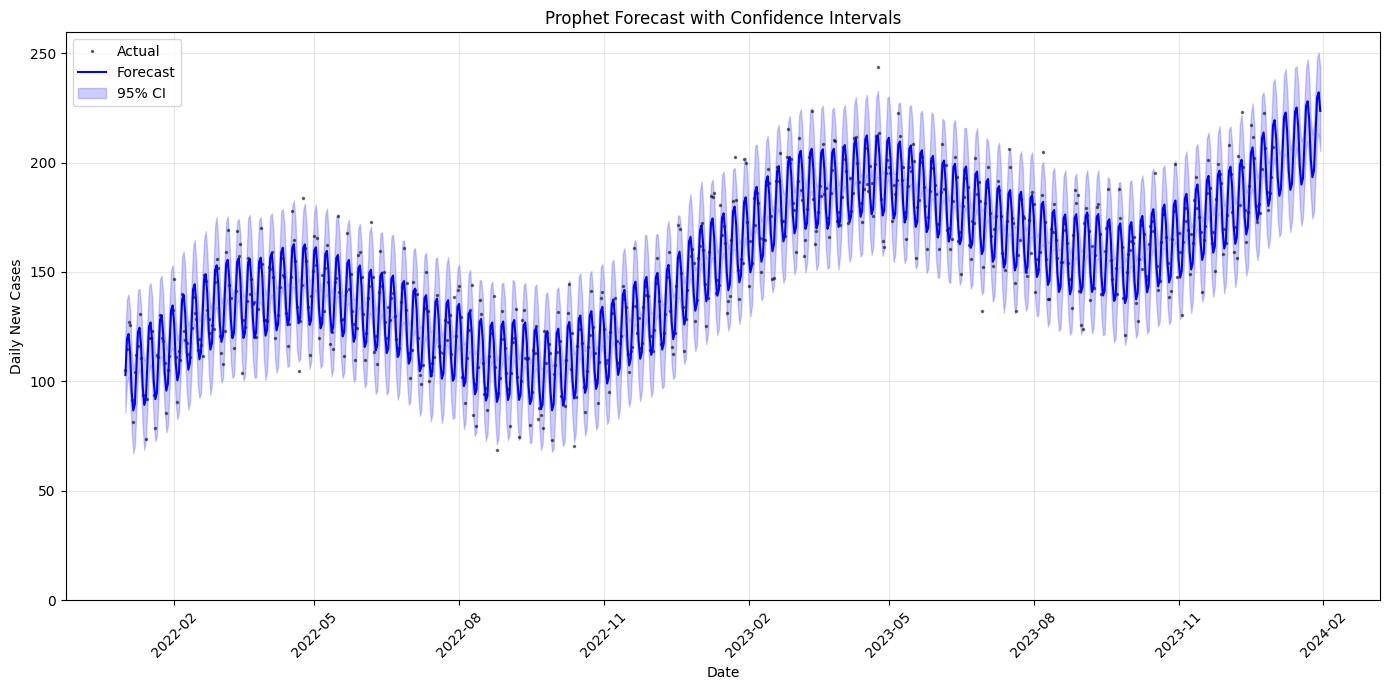

In [69]:
# Plot forecast with confidence intervals
fig = plot_forecast(
    df=sample_df,
    forecast=wrapper_forecast,
    title='Prophet Forecast with Confidence Intervals'
)
plt.show()

### 9.2 plot_model_comparison()

2025-12-16 02:01:33 - utils - INFO - Creating model comparison plot for 4 models
2025-12-16 02:01:33 - utils - INFO - Model comparison plot created


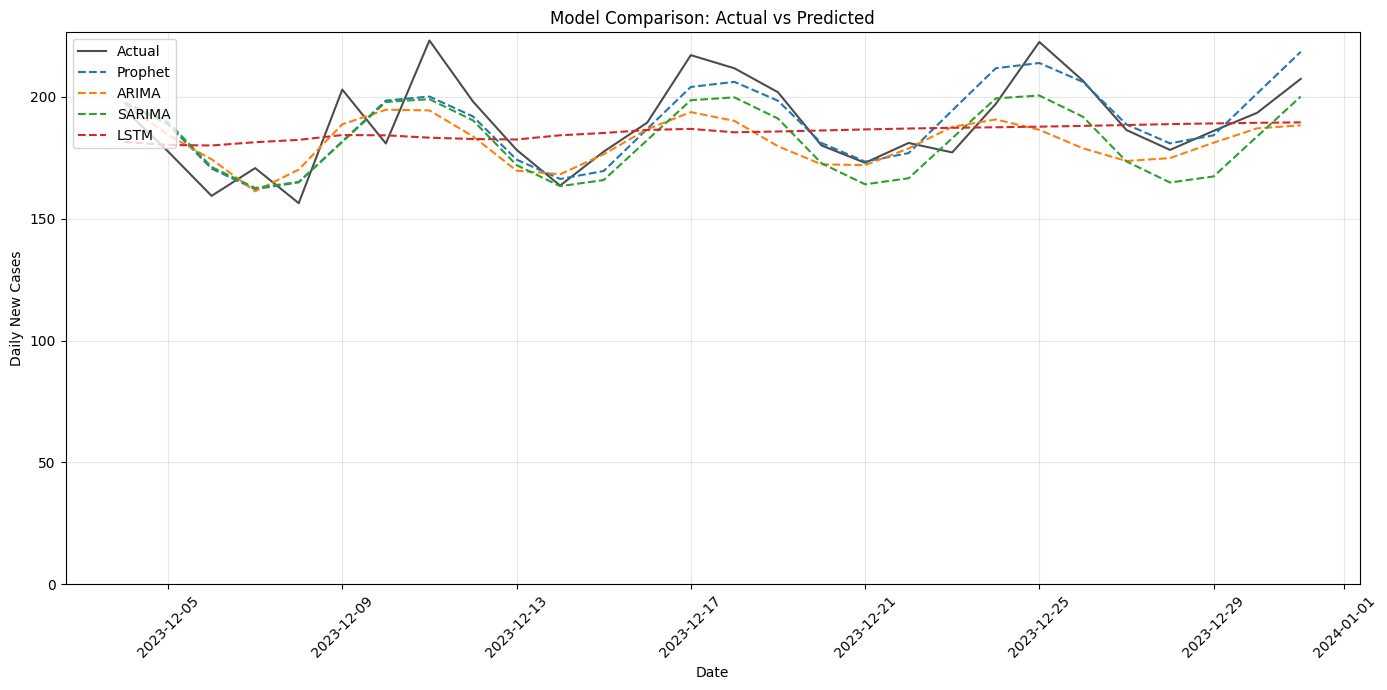

In [70]:
# Plot all models vs actual
fig = plot_model_comparison(
    actual_dates=test_df['ds'],
    actual_values=actual,
    predictions=all_predictions,
    title='Model Comparison: Actual vs Predicted'
)
plt.show()

### 9.3 plot_training_history()

2025-12-16 02:01:33 - utils - INFO - Creating training history plot
2025-12-16 02:01:33 - utils - INFO - Training history plot created


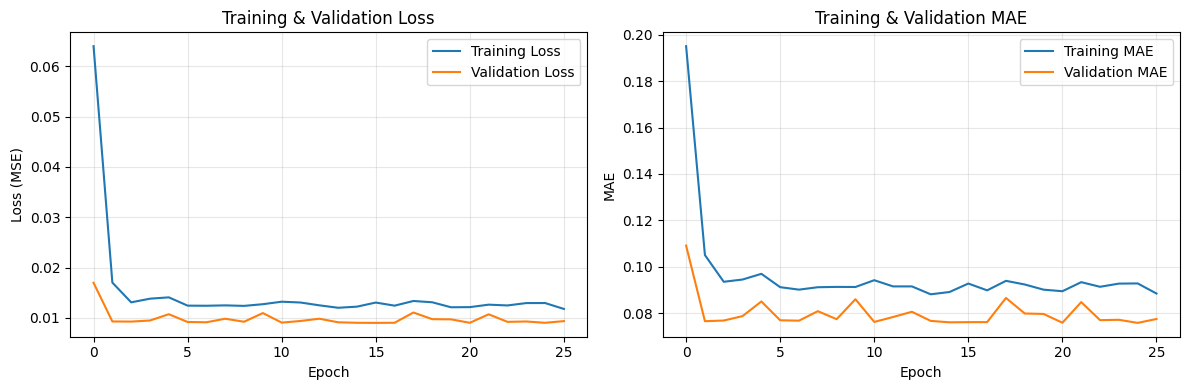

In [71]:
# Plot LSTM training history
fig = plot_training_history(history)
plt.show()

---

## 10. Helper Functions

Additional utility functions.

### 10.1 prepare_prophet_data()

Transform data into Prophet's required format.

In [72]:
# Function signature
help(prepare_prophet_data)

Help on function prepare_prophet_data in module utils:

prepare_prophet_data(df: pandas.core.frame.DataFrame, date_col: str = 'Date', target_col: str = 'Confirmed', compute_daily: bool = True) -> pandas.core.frame.DataFrame
    Transform data into Prophet-required format (ds, y columns).
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    date_col : str
        Name of date column
    target_col : str
        Name of target variable column (cumulative cases)
    compute_daily : bool
        If True, compute daily new cases from cumulative
        
    Returns
    -------
    pd.DataFrame
        Prophet-formatted dataframe with 'ds' and 'y' columns



---

## Summary

This notebook demonstrated the following `utils.py` components:

### Classes
| Class | Description |
|-------|-------------|
| `ProphetWrapper` | Enhanced Prophet interface with method chaining |
| `LSTMForecaster` | LSTM neural network for time series |

### Data Functions
| Function | Description |
|----------|-------------|
| `load_jhu_timeseries()` | Load JHU COVID-19 data |
| `get_available_countries()` | List available countries |
| `prepare_prophet_data()` | Transform to Prophet format |
| `summarize_data()` | Generate summary statistics |
| `train_test_split_temporal()` | Time-based train/test split |

### Intervention Functions
| Function | Description |
|----------|-------------|
| `create_intervention_dataframe()` | Convert dict to Prophet holidays |
| `get_us_covid_interventions()` | Get US intervention dates |
| `get_country_interventions()` | Get country-specific interventions |

### Model Functions
| Function | Description |
|----------|-------------|
| `fit_arima()` | Fit ARIMA model |
| `fit_sarima()` | Fit SARIMA model |
| `forecast_arima()` | Generate ARIMA forecast |
| `forecast_sarima()` | Generate SARIMA forecast |

### Evaluation Functions
| Function | Description |
|----------|-------------|
| `calculate_rmse()` | Root Mean Squared Error |
| `calculate_mae()` | Mean Absolute Error |
| `calculate_smape()` | Symmetric MAPE |
| `evaluate_forecast()` | All metrics at once |
| `compare_models()` | Compare multiple models |

### Visualization Functions
| Function | Description |
|----------|-------------|
| `plot_forecast()` | Plot forecast with CI |
| `plot_components()` | Plot trend/seasonality |
| `plot_model_comparison()` | Compare predictions |
| `plot_training_history()` | LSTM training curves |

In [73]:
print("="*60)
print("Prophet API & Wrapper Functions Tutorial Complete!")
print("="*60)

Prophet API & Wrapper Functions Tutorial Complete!
